[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rmartimarly/ImageRegistrationTutorial/blob/main/1Intro_image_registration.ipynb)

# Tutorial on Intensity Based registration

Robert Martí robert.marti@udg.edu
University of Girona



A radiologist comes to your office and asks to help him for a very complicated problem: he has two images of the same patient and wants to find the changes the had happened in the two images: lesions, etc.

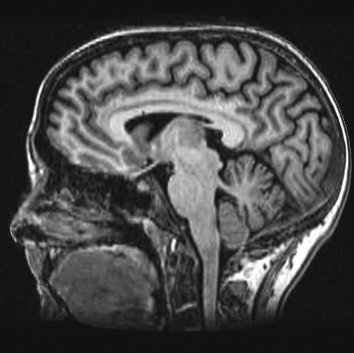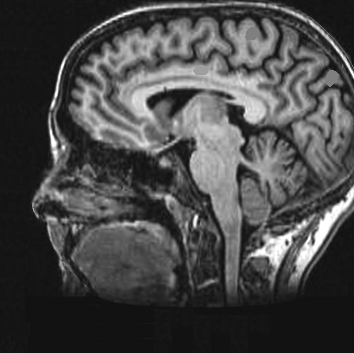

Could we measure how similar are two images?

### Import libraries

In [1]:
# !pip install numpy
# !pip install opencv-python
# !pip install pyplot



In [2]:
import numpy as np
import cv2

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.utils import get_file
import os

### Loading images

In [3]:
# Import medical data - we are going to use the head and neck CT data to show the losses.
main_path = os.getcwd()

data_path = "files"
file_path1 = os.path.abspath(os.path.join(main_path,data_path, "brain1.png"))
origin1 = "https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain1.png"
file_path2 = os.path.abspath(os.path.join(main_path,data_path, "brain2_lesion.png"))
origin2 = "https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain2_lesion.png"

if not os.path.exists(data_path):
    os.makedirs(os.path.join(main_path, data_path))

if os.path.exists(file_path1):
    os.remove(file_path1)   
if os.path.exists(file_path2):
    os.remove(file_path2)   
       
get_file(file_path1, origin1)
get_file(file_path2, origin2)

# print("Download sample images: %s." % file_path1)

114688/111719 [==============================] - 0s 0us/step


'/home/robert/src/regTutorial/files/brain2_lesion.png'

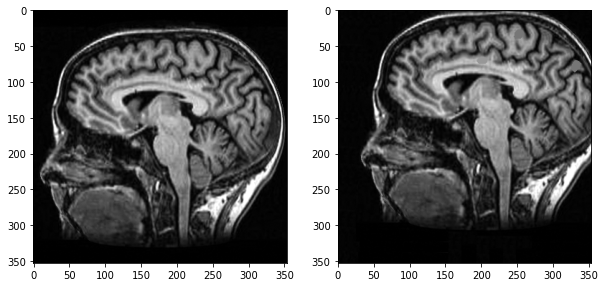

In [5]:
# Load both images
img_ref = cv2.imread(file_path1, 0)
img_tar= cv2.imread(file_path2,0)
f = plt.figure(figsize = (10,200))
f.add_subplot(1,2, 1)
plt.imshow(img_ref, cmap='gray')    
f.add_subplot(1,2, 2)
plt.imshow(img_tar, cmap='gray')
plt.show(block=True)



### Smooth images a bit (works better!)

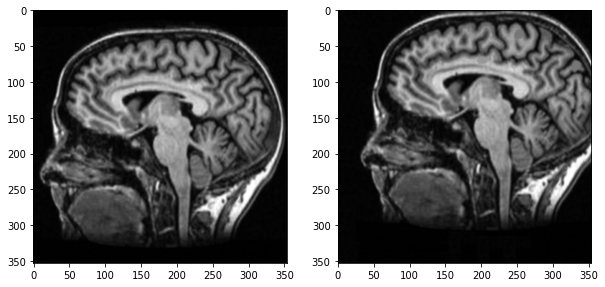

In [6]:
# smoothing imges
kernel = np.ones((3,3),np.float32)/9
img_ref_s = cv2.filter2D(img_ref,-1,kernel)
img_tar_s = cv2.filter2D(img_tar,-1,kernel)

f = plt.figure(figsize = (10,200))
f.add_subplot(1,2, 1)
plt.imshow(img_ref_s, cmap='gray')    
f.add_subplot(1,2, 2)
plt.imshow(img_tar_s, cmap='gray')
plt.show(block=True)

### Can we measure the similarity between two images?


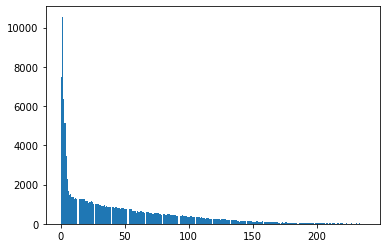

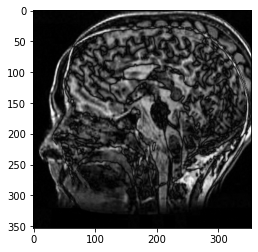

42.28577487556217
0.0
8.997919571612742


In [8]:
rms = np.abs(img_ref.astype(float)-img_tar.astype(float))
# histogram, bin_edges = np.histogram(rms, bins=256)
# plt.plot(rms)

plt.hist(rms.flatten(), bins=256)
plt.show()
plt.imshow(rms, cmap='gray')
plt.show()

print(np.sum(rms)/img_ref.size)

rms = abs(img_ref-img_ref)
print(np.sum(rms)/img_ref.size)

rms = abs((img_ref-img_tar)**2)
print(np.sqrt(np.sum(rms)/img_ref.size))



### Let's put this into a function

In [9]:
def error_rms (im1, im2):
    rms = abs((im1.astype(float)-im2.astype(float))**2)
    rms = np.sqrt(np.sum(rms)/im1.size)
    return rms


In [11]:
print (error_rms (img_ref, img_tar))
print (error_rms (img_ref_s, img_tar_s))


61.76674431871843
59.003760141944426


### Transform an Image: translation only.


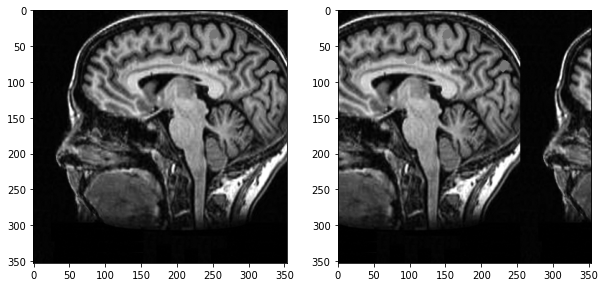

In [12]:
img_tarM = np.roll(img_tar,-100 , axis=1)
f = plt.figure(figsize = (10,200))
f.add_subplot(1,2, 1)
plt.imshow(img_tar, cmap='gray')    
f.add_subplot(1,2, 2)
plt.imshow(img_tarM, cmap='gray')
plt.show(block=True)

### All together: error as a function of the translation parameters

First we translate the moving image and then compute the error.

In [13]:
def funcio_error(img_r,img_m,params):
#     print (np.round(params.astype(int),0))
    
    img_tarM = np.roll(img_m,np.round(params).astype(int), axis=(0,1))
    error = error_rms(img_tarM,img_r) # error actual
    return error
    

### Let's plot the parameter space

In [14]:
xaxis = np.linspace(0, 50, 51, dtype=int)
yaxis = np.linspace(-50, 0, 51,dtype=int)
zval = np.zeros([len(xaxis),len(yaxis)])
X, Y = np.meshgrid(xaxis, yaxis)

In [17]:
params = np.zeros(2)
for i in range(len(X)):
    for j in range(len(Y)):
        params[0] = X[i,j]
        params[1] = Y[i,j]
        zval[i,j] = funcio_error(img_ref_s,img_tar_s, params)

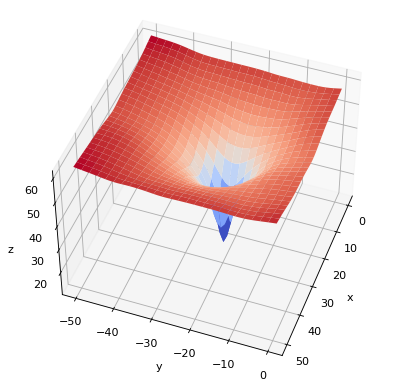

In [18]:
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection="3d")

# ax.plot_wireframe(X, Y,zval, color='green')
ax.plot_surface(X, Y,zval, cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.view_init(120, 30)
ax.view_init(45, 20)

plt.show()


### Register!
Find the best parameters (translation) that minimise the error.




--> 0 - params [0. 0.]
	Err_act (metric):  59.003760141944426 Error wrt params:  [58.88451312 59.29252404]
	Gradient:  [-0.11924702  0.2887639 ] Step_size  0.0433145852166831 0.0433145852166831
--> 1 - params [ 0.01788705 -0.04331459]
	Err_act (metric):  59.003760141944426 Error wrt params:  [58.88451312 59.29252404]
	Gradient:  [-0.11924702  0.2887639 ] Step_size  0.0433145852166831 0.0433145852166831
--> 2 - params [ 0.03577411 -0.08662917]
	Err_act (metric):  59.003760141944426 Error wrt params:  [58.88451312 59.29252404]
	Gradient:  [-0.11924702  0.2887639 ] Step_size  0.04331458521668309 0.04331458521668309
--> 3 - params [ 0.05366116 -0.12994376]
	Err_act (metric):  59.003760141944426 Error wrt params:  [58.88451312 59.29252404]
	Gradient:  [-0.11924702  0.2887639 ] Step_size  0.043314585216683105 0.043314585216683105
--> 4 - params [ 0.07154821 -0.17325834]
	Err_act (metric):  59.003760141944426 Error wrt params:  [58.88451312 59.29252404]
	Gradient:  [-0.11924702  0.2887639 ] S

	Err_act (metric):  57.57631361675101 Error wrt params:  [57.43311549 57.83730581]
	Gradient:  [-0.14319813  0.26099219] Step_size  0.03914882826007293 0.03914882826007293
--> 80 - params [ 1.563119   -3.57133475]
	Err_act (metric):  57.57631361675101 Error wrt params:  [57.43311549 57.83730581]
	Gradient:  [-0.14319813  0.26099219] Step_size  0.03914882826007293 0.03914882826007293
--> 81 - params [ 1.58459872 -3.61048358]
	Err_act (metric):  57.57631361675101 Error wrt params:  [57.43311549 57.83730581]
	Gradient:  [-0.14319813  0.26099219] Step_size  0.03914882826007293 0.03914882826007293
--> 82 - params [ 1.60607844 -3.64963241]
	Err_act (metric):  57.57631361675101 Error wrt params:  [57.43311549 57.83730581]
	Gradient:  [-0.14319813  0.26099219] Step_size  0.03914882826007293 0.03914882826007293
--> 83 - params [ 1.62755815 -3.68878124]
	Err_act (metric):  57.57631361675101 Error wrt params:  [57.43311549 57.83730581]
	Gradient:  [-0.14319813  0.26099219] Step_size  0.0391488282

	Err_act (metric):  57.16644141990547 Error wrt params:  [57.00657601 57.43311549]
	Gradient:  [-0.15986541  0.26667407] Step_size  0.04000111076211876 0.04000111076211876
--> 121 - params [ 2.53549009 -5.10172298]
	Err_act (metric):  57.16644141990547 Error wrt params:  [57.00657601 57.43311549]
	Gradient:  [-0.15986541  0.26667407] Step_size  0.04000111076211876 0.04000111076211876
--> 122 - params [ 2.5594699  -5.14172409]
	Err_act (metric):  57.16644141990547 Error wrt params:  [57.00657601 57.43311549]
	Gradient:  [-0.15986541  0.26667407] Step_size  0.04000111076211876 0.04000111076211876
--> 123 - params [ 2.58344971 -5.18172521]
	Err_act (metric):  57.16644141990547 Error wrt params:  [57.00657601 57.43311549]
	Gradient:  [-0.15986541  0.26667407] Step_size  0.04000111076211876 0.04000111076211876
--> 124 - params [ 2.60742953 -5.22172632]
	Err_act (metric):  57.16644141990547 Error wrt params:  [57.00657601 57.43311549]
	Gradient:  [-0.15986541  0.26667407] Step_size  0.040001

	Err_act (metric):  56.422305738792744 Error wrt params:  [56.18494542 56.70837645]
	Gradient:  [-0.23736032  0.28607071] Step_size  0.04291060635405586 0.04291060635405586
--> 163 - params [ 3.78171236 -6.75633167]
	Err_act (metric):  56.422305738792744 Error wrt params:  [56.18494542 56.70837645]
	Gradient:  [-0.23736032  0.28607071] Step_size  0.04291060635405586 0.04291060635405586
--> 164 - params [ 3.81731641 -6.79924228]
	Err_act (metric):  56.422305738792744 Error wrt params:  [56.18494542 56.70837645]
	Gradient:  [-0.23736032  0.28607071] Step_size  0.04291060635405586 0.04291060635405586
--> 165 - params [ 3.85292046 -6.84215288]
	Err_act (metric):  56.422305738792744 Error wrt params:  [56.18494542 56.70837645]
	Gradient:  [-0.23736032  0.28607071] Step_size  0.04291060635405586 0.04291060635405586
--> 166 - params [ 3.88852451 -6.88506349]
	Err_act (metric):  56.422305738792744 Error wrt params:  [56.18494542 56.70837645]
	Gradient:  [-0.23736032  0.28607071] Step_size  0.0

	Err_act (metric):  54.580588237450804 Error wrt params:  [54.2042396  54.94520587]
	Gradient:  [-0.37634864  0.36461764] Step_size  0.056452296086353826 0.056452296086353826
--> 237 - params [  7.06032833 -10.26457913]
	Err_act (metric):  54.580588237450804 Error wrt params:  [54.2042396  54.94520587]
	Gradient:  [-0.37634864  0.36461764] Step_size  0.056452296086353826 0.056452296086353826
--> 238 - params [  7.11678063 -10.31927177]
	Err_act (metric):  54.580588237450804 Error wrt params:  [54.2042396  54.94520587]
	Gradient:  [-0.37634864  0.36461764] Step_size  0.056452296086353826 0.056452296086353826
--> 239 - params [  7.17323293 -10.37396442]
	Err_act (metric):  54.580588237450804 Error wrt params:  [54.2042396  54.94520587]
	Gradient:  [-0.37634864  0.36461764] Step_size  0.056452296086353826 0.056452296086353826
--> 240 - params [  7.22968522 -10.42865706]
	Err_act (metric):  54.580588237450804 Error wrt params:  [54.2042396  54.94520587]
	Gradient:  [-0.37634864  0.36461764

--> 275 - params [  9.85206154 -12.40240993]
	Err_act (metric):  52.436615432214424 Error wrt params:  [51.87735945 52.88026772]
	Gradient:  [-0.55925599  0.44365229] Step_size  0.08388839781772361 0.08388839781772361
--> 276 - params [  9.93594994 -12.46895777]
	Err_act (metric):  52.436615432214424 Error wrt params:  [51.87735945 52.88026772]
	Gradient:  [-0.55925599  0.44365229] Step_size  0.08388839781772361 0.08388839781772361
--> 277 - params [ 10.01983834 -12.53550562]
	Err_act (metric):  52.08799439779532 Error wrt params:  [51.45375069 52.43661543]
	Gradient:  [-0.6342437   0.34862103] Step_size  0.09513655555226741 0.09513655555226741
--> 278 - params [ 10.11497489 -12.58779877]
	Err_act (metric):  52.08799439779532 Error wrt params:  [51.45375069 52.43661543]
	Gradient:  [-0.6342437   0.34862103] Step_size  0.09513655555226741 0.09513655555226741
--> 279 - params [ 10.21011145 -12.64009193]
	Err_act (metric):  52.08799439779532 Error wrt params:  [51.45375069 52.43661543]
	G

	Err_act (metric):  48.43089922567969 Error wrt params:  [47.59866814 48.99969338]
	Gradient:  [-0.83223109  0.56879415] Step_size  0.12483466317728009 0.12483466317728009
--> 318 - params [ 14.33423578 -15.28403569]
	Err_act (metric):  48.43089922567969 Error wrt params:  [47.59866814 48.99969338]
	Gradient:  [-0.83223109  0.56879415] Step_size  0.12483466317728009 0.12483466317728009
--> 319 - params [ 14.45907044 -15.36935482]
	Err_act (metric):  48.43089922567969 Error wrt params:  [47.59866814 48.99969338]
	Gradient:  [-0.83223109  0.56879415] Step_size  0.12483466317728009 0.12483466317728009
--> 320 - params [ 14.58390511 -15.45467394]
	Err_act (metric):  47.598668137831154 Error wrt params:  [46.74379842 48.28325618]
	Gradient:  [-0.85486972  0.68458804] Step_size  0.12823045766121233 0.12823045766121233
--> 321 - params [ 14.71213556 -15.55736214]
	Err_act (metric):  46.93857805636453 Error wrt params:  [45.94864834 47.59866814]
	Gradient:  [-0.98992971  0.66009008] Step_size 

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 361 - params [ 23.69774645 -22.50204989]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 362 - params [ 23.39497386 -21.9404154 ]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 363 - params [ 23.84082699 -22.30105907]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 364 - params [ 23.39375462 -22.79864466]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.471

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 406 - params [ 23.54447383 -22.07006727]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 407 - params [ 23.09740145 -22.56765285]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 408 - params [ 23.45337326 -22.09589968]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 409 - params [ 23.89922639 -22.45654336]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.497

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 475 - params [ 23.51498238 -22.4167053 ]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 476 - params [ 23.06791001 -22.91429088]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 477 - params [ 23.42388182 -22.44253771]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 478 - params [ 23.86973495 -22.80318139]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.561

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 514 - params [ 23.49071166 -22.96644552]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 515 - params [ 23.84668347 -22.49469235]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 516 - params [ 23.3996111  -22.99227793]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 517 - params [ 23.75558291 -22.52052476]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.561

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 556 - params [ 23.07256779 -22.98038366]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 557 - params [ 23.4285396  -22.50863049]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 558 - params [ 23.78451141 -22.03687732]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 559 - params [ 23.33743904 -22.5344629 ]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4

	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 598 - params [ 23.78153052 -22.63055668]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 599 - params [ 23.47875793 -22.06892219]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 600 - params [ 23.92461106 -22.42956587]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 601 - params [ 23.47753869 -22.92715145]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.471

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 674 - params [ 23.4101459  -22.26623424]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 675 - params [ 23.85599903 -22.62687792]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 676 - params [ 23.55322644 -22.06524343]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 677 - params [ 23.10615407 -22.56282901]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.471

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 744 - params [ 23.16776319 -22.88363463]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 745 - params [ 23.523735   -22.41188146]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 746 - params [ 23.07666262 -22.90946704]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 747 - params [ 23.43263443 -22.43771387]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 784 - params [ 23.40958296 -22.12922483]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 785 - params [ 23.85543609 -22.48986851]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 786 - params [ 23.40836371 -22.98745409]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 787 - params [ 23.76433552 -22.51570092]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.561

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 826 - params [ 23.0813204  -22.97555982]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 827 - params [ 23.43729222 -22.50380665]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 828 - params [ 23.79326403 -22.03205348]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 829 - params [ 23.34619165 -22.52963906]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4

	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 869 - params [ 23.67789274 -22.60762611]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 870 - params [ 23.37512015 -22.04599162]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 871 - params [ 23.82097328 -22.4066353 ]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 872 - params [ 23.37390091 -22.90422088]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.471

	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 913 - params [ 23.16864831 -22.64739667]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 914 - params [ 23.52462012 -22.1756435 ]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 915 - params [ 23.07754775 -22.67322908]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 916 - params [ 23.43351956 -22.20147591]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 917 - params [ 23.87937269 -22.56211958]
	Err

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 959 - params [ 23.69540992 -22.34923451]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 960 - params [ 23.24833755 -22.84682009]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 961 - params [ 23.60430936 -22.37506692]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 962 - params [ 23.15723698 -22.8726525 ]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1005 - params [ 23.75380932 -22.50471879]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 1006 - params [ 23.45103673 -21.9430843 ]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1007 - params [ 23.89688986 -22.30372798]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1008 - params [ 23.44981749 -22.80131356]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1052 - params [ 23.50943614 -22.09856858]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1053 - params [ 23.06236376 -22.59615416]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1054 - params [ 23.41833557 -22.12440099]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1055 - params [ 23.8641887  -22.48504467]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1094 - params [ 23.18117358 -22.94490357]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1095 - params [ 23.53714539 -22.4731504 ]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1096 - params [ 23.09007302 -22.97073598]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1097 - params [ 23.44604483 -22.49898281]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size 

	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1140 - params [ 23.9421163  -22.41991819]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1141 - params [ 23.49504392 -22.91750377]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1142 - params [ 23.85101573 -22.4457506 ]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1143 - params [ 23.40394336 -22.94333618]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size 

--> 1186 - params [ 23.1075902  -22.71234437]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1187 - params [ 23.46356201 -22.2405912 ]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1188 - params [ 23.90941514 -22.60123488]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 1189 - params [ 23.60664255 -22.03960039]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1190 - params [ 23.15957018 -22.53718597]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gra

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1230 - params [ 23.25709016 -22.84199625]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1231 - params [ 23.61306197 -22.37024307]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1232 - params [ 23.1659896  -22.86782866]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1233 - params [ 23.52196141 -22.39607549]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1300 - params [ 23.81775163 -22.49005789]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1301 - params [ 23.37067926 -22.98764347]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1302 - params [ 23.72665107 -22.5158903 ]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 1303 - params [ 23.42387848 -21.95425581]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0

	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1340 - params [ 23.91527162 -22.79486816]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 1341 - params [ 23.61249903 -22.23323367]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1342 - params [ 23.16542665 -22.73081925]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1343 - params [ 23.52139846 -22.25906608]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.4

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1382 - params [ 23.49712774 -22.8088063 ]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1383 - params [ 23.85309956 -22.33705313]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1384 - params [ 23.40602718 -22.83463871]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1385 - params [ 23.76199899 -22.36288554]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0

	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1430 - params [ 23.46442658 -22.99012299]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1431 - params [ 23.8203984  -22.51836982]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 1432 - params [ 23.51762581 -21.95673533]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1433 - params [ 23.07055343 -22.45432091]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1434 - params [ 23.51640656 -22.81496459]
	

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1477 - params [ 23.2200534  -22.58397279]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1478 - params [ 23.57602521 -22.11221962]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1479 - params [ 23.12895284 -22.6098052 ]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1480 - params [ 23.48492465 -22.13805203]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size 

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1523 - params [ 23.51263391 -22.51263385]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 1524 - params [ 23.20986132 -21.95099936]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1525 - params [ 23.65571445 -22.31164304]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1526 - params [ 23.20864207 -22.80922862]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1570 - params [ 23.35814204 -22.93888049]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1571 - params [ 23.71411385 -22.46712732]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1572 - params [ 23.26704148 -22.9647129 ]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1573 - params [ 23.62301329 -22.49295973]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0

	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1646 - params [ 23.87968292 -22.43761614]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1647 - params [ 23.43261055 -22.93520172]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1648 - params [ 23.78858236 -22.46344855]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1649 - params [ 23.34150999 -22.96103413]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size 

	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 1689 - params [ 23.58332976 -22.20662433]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1690 - params [ 23.13625738 -22.70420991]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1691 - params [ 23.4922292  -22.23245674]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1692 - params [ 23.93808232 -22.59310042]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1759 - params [ 23.34094704 -22.82402473]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1760 - params [ 23.69691885 -22.35227156]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1761 - params [ 23.24984648 -22.84985714]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1762 - params [ 23.60581829 -22.37810397]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1827 - params [ 23.09978357 -22.58319586]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1828 - params [ 23.45575538 -22.11144269]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1829 - params [ 23.90160851 -22.47208637]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1830 - params [ 23.45453613 -22.96967195]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size 

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1899 - params [ 23.80352558 -22.03026669]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1900 - params [ 23.3564532  -22.52785227]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 1901 - params [ 23.71242501 -22.0560991 ]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1902 - params [ 23.26535264 -22.55368468]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size 

	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1940 - params [ 23.68815429 -22.60583932]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 1941 - params [ 23.3853817  -22.04420483]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 1942 - params [ 23.83123483 -22.40484851]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 1943 - params [ 23.38416246 -22.90243409]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0

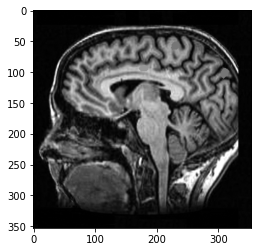

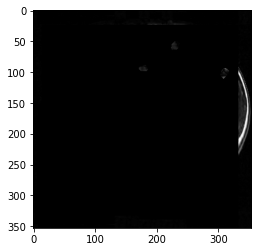

In [29]:
import time

err = np.zeros(2)
params = np.zeros(2)

rate = 0.15 # Learning rate ??
precision = 0.000001 #This tells us when to stop the algorithm
max_iters = 2000 # maximum number of iterations
iters = 0 #iteration counter
g_step = 1 # gradient step: too small more iterations are needed, too large may jump out the solution

step_size = 10

while step_size > precision and iters < max_iters:
       
#     if (iters > max_iters/2): rate = 0.015
    prev_params = np.copy(params)
    print("-->",iters, "- params",params)
    error_act = funcio_error(img_ref_s,img_tar_s, params)
        
    # Error modificant lleugerament els paràmetres
    err[0] = funcio_error(img_ref_s,img_tar_s,params+[g_step, 0])
    err[1] = funcio_error(img_ref_s,img_tar_s,params+[0, g_step])
                         
    grad = err-error_act
    
    params = params - rate * grad      
        
    new_step_size = np.max(abs(prev_params-params)) #Change in x
    step_size = new_step_size
    iters +=1 #iteration count

    print ('\tErr_act (metric): ', error_act, 'Error wrt params: ', err)
    print ('\tGradient: ', grad,"Step_size ", step_size, new_step_size)
    
print("The local minimum occurs at", params)
plt.show(block=True)

img_tarM = np.roll(img_tar,np.round(params).astype(int), axis=(0,1))
plt.imshow(img_tarM, cmap='gray')
plt.show()
rms = np.abs(img_ref.astype(float)-img_tarM.astype(float))


plt.imshow(rms, cmap='gray')
plt.show()



### We analyse the difference image

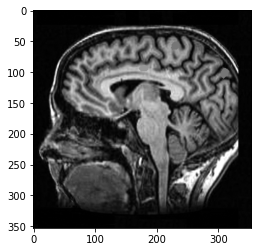

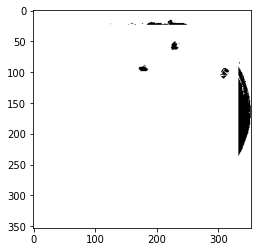

In [22]:

img_tarM = np.roll(img_tar,np.round(params).astype(int), axis=(0,1))
plt.imshow(img_tarM, cmap='gray')
plt.show()
rms = np.abs(img_ref.astype(float)-img_tarM.astype(float))

rms = (rms>10) * 255

plt.imshow(255-rms, cmap='gray')
plt.show()
